# Чтение данных

Импорт необходимых библиотек

In [1]:
%matplotlib inline

import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score

from __future__ import print_function

import tensorflow as tf
tf.set_random_seed(1)


# Беглый взгляд на данные

In [2]:
df_train = pd.read_csv('train_sample.csv')
df_test = pd.read_csv('test_sample.csv')

print(df_train.columns)
df_train.head()

Index([u'system:index', u'NDSI', u'NDVI', u'NDWI', u'RND', u'blue',
       u'currentDate', u'date', u'dayNumber', u'green', u'name', u'nir',
       u'randomDayNum', u'realmed_NDSI', u'realmed_NDVI', u'realmed_NDWI',
       u'realmed_blue', u'realmed_green', u'realmed_nir', u'realmed_red',
       u'realmed_swir1', u'realmed_swir2', u'red', u'swir1', u'swir2',
       u'tmpDayRND', u'tmpYearRND', u'tree_canopy_cover', u'uncertainty',
       u'.geo'],
      dtype='object')


system:index      NDSI      NDVI  \
0  1_1_1_0000e5da29c0b1fa60c2_1_1_1_0000e5da29c0b... -0.208550  0.152891   
1  1_1_1_0000e5da29c0b1fa60c2_1_1_1_0000e5da29c0b... -0.383919  0.155118   
2  1_1_1_0000e5da29c0b1fa60c2_1_1_1_0000e5da29c0b... -0.378921  0.201213   
3  1_1_1_0000e5da29c0b1fa60c2_1_1_1_0000e5da29c0b... -0.290674  0.139646   
4  1_1_1_0000e5da29c0b1fa60c2_1_1_1_0000e5da29c0b... -0.105609  0.214587   

       NDWI       RND      blue  currentDate     date  dayNumber     green  \
0 -0.358013  0.569619  0.100930      17187.0  17187.0   0.010959  0.107351   
1 -0.520512  0.569619  0.182242      17187.0  17187.0   0.010959  0.193009   
2 -0.565559  0.569619  0.185526      17187.0  17187.0   0.010959  0.194195   
3 -0.419531  0.569619  0.137983      17187.0  17187.0   0.010959  0.143904   
4 -0.350659  0.569619  0.086108      17187.0  17187.0   0.010959  0.092052   

   ...  realmed_swir1  realmed_swir2       red     swir1     swir2  tmpDayRND  \
0  ...         0.0603         0.0420  0.101039  0.042280  0.039435   0.599079   
1  ...         0.0957         0.0896  0.199844  0.079833  0.071455   0.599079   
2  ...         0.1007         0.0791  0.194148  0.076418  0.069890   0.599079   
3  ...         0.0805         0.0737  0.141044  0.052959  0.048899   0.599079   
4  ...         0.0855         0.0579  0.087296  0.044433  0.038058   0.599079   

   tmpYearRND  tree_canopy_cover  uncertainty  .geo  
0    0.625697               0.62     0.174875   NaN  
1    0.625697               0.60     0.175930   NaN  
2    0.625697               0.68     0.175045   NaN  
3    0.625697               0.64     0.174212   NaN  
4    0.625697               0.64     0.174212   NaN  

[5 rows x 30 columns]

В файлах лежат яркости пикселей в соотвествующих каналах, прочитанные в границах обучающих полигонов. Все полигоны разные, ID полигона кодируется в поле "system:index" (но оно устроено сложно и каждый раз перегенерируется с разным числом подчеркиваний), поэтому в качестве идентификатора полигона можно использовать поле "RND", содержащее случайное число. Вероятность того, что разные полигоны получат одинаковое значение случайного числа есть, но не очень велика.

Различать же пиксели, принадлежащие разным полигонам нам очень важно из-за пространственной автокорреляции: нужно чтобы в обучающую и тестовую выборки попадали пиксели из разных полигонов.

In [3]:
band_names = ['swir2','swir1','nir','red','green','blue', 'NDVI', 'NDSI', 'NDWI']
real_band_names = ['realmed_'+n for n in band_names]

names = ['RND', 'name', 'date', 'dayNumber', 'tree_canopy_cover'] + band_names + real_band_names
print(names)

df_train = df_train[names]
df_test = df_test[names]
df_test.head()

['RND', 'name', 'date', 'dayNumber', 'tree_canopy_cover', 'swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI']


RND    name     date  dayNumber  tree_canopy_cover     swir2  \
0  0.989548  Change  17187.0   0.010959               0.60  0.023530   
1  0.989548  Change  17187.0   0.010959               0.49  0.054194   
2  0.989548  Change  17187.0   0.010959               0.54  0.053797   
3  0.989548  Change  17187.0   0.010959               0.63  0.070193   
4  0.989548  Change  17187.0   0.010959               0.64  0.046102   

      swir1       nir       red     green      ...           NDWI  \
0  0.028641  0.096547  0.082891  0.082103      ...      -0.173175   
1  0.064952  0.216903  0.182502  0.177173      ...      -0.350741   
2  0.063689  0.204520  0.174780  0.172326      ...      -0.343435   
3  0.085331  0.300934  0.258343  0.255790      ...      -0.571704   
4  0.055031  0.183381  0.158101  0.153973      ...      -0.310993   

   realmed_swir2  realmed_swir1  realmed_nir  realmed_red  realmed_green  \
0        0.06305         0.0881       0.3288      0.29095        0.28525   
1        0.06570         0.0906       0.3527      0.31330        0.29690   
2        0.06570         0.1008       0.3208      0.30100        0.28985   
3        0.06045         0.0881       0.3288      0.29500        0.27585   
4        0.07370         0.0931       0.3501      0.31325        0.29925   

   realmed_blue  realmed_NDVI  realmed_NDSI  realmed_NDWI  
0       0.28860      0.061056     -0.535234     -0.577351  
1       0.29880      0.059104     -0.551646     -0.591551  
2       0.29470      0.031915     -0.499831     -0.523802  
3       0.28245      0.054104     -0.540148     -0.577391  
4       0.29885      0.055660     -0.541820     -0.579954  

[5 rows x 23 columns]

In [4]:
df_train.groupby('RND').agg(['mean', 'count', 'var'])

date            dayNumber            tree_canopy_cover        \
             mean count  var      mean count  var              mean count   
RND                                                                         
0.000182  16216.0     2  0.0  0.353425     2  0.0          0.645000     2   
0.001205  17747.0     4  0.0  0.545206     4  0.0          0.205000     4   
0.001323  17187.0    15  0.0  0.010959    15  0.0          0.690667    15   
0.001637  16256.0     1  NaN  0.463014     1  NaN          0.150000     1   
0.001682  17359.0    10  0.0  0.482192    10  0.0          0.683000    10   
0.002113     -1.0    27  0.0  0.586301    27  0.0          0.652963    27   
0.002268     -1.0    18  0.0  0.167123    18  0.0          0.653889    18   
0.003426     -1.0   266  0.0  0.410959   266  0.0          0.679662   266   
0.003757  17133.0     4  0.0  0.865753     4  0.0          0.625000     4   
0.003779  16257.0     4  0.0  0.465753     4  0.0          0.675000     4   
0.004392  17407.0     2  0.0  0.613699     2  0.0          0.470000     2   
0.004454  17187.0     5  0.0  0.010959     5  0.0          0.620000     5   
0.005258  17187.0    11  0.0  0.010959    11  0.0          0.634545    11   
0.005771  16176.0     7  0.0  0.243836     7  0.0          0.692857     7   
0.007054  16216.0    10  0.0  0.353425    10  0.0          0.612000    10   
0.007984  17407.0     3  0.0  0.613699     3  0.0          0.706667     3   
0.008232     -1.0    11  0.0  0.427397    11  0.0          0.574545    11   
0.008481  17455.0     3  0.0  0.745205     3  0.0          0.360000     3   
0.008681  16281.0    23  0.0  0.531507    23  0.0          0.653478    23   
0.008693  17187.0     6  0.0  0.010959     6  0.0          0.695000     6   
0.008847     -1.0     6  0.0  0.723288     6  0.0          0.546667     6   
0.009444  17311.0    21  0.0  0.350685    21  0.0          0.702381    21   
0.010036     -1.0    24  0.0  0.920548    24  0.0          0.666250    24   
0.010570  17375.0     5  0.0  0.526027     5  0.0          0.670000     5   
0.010662  16833.0     6  0.0  0.043836     6  0.0          0.645000     6   
0.011389  17117.0     2  0.0  0.821918     2  0.0          0.665000     2   
0.012369  16192.0    24  0.0  0.287671    24  0.0          0.672917    24   
0.012485     -1.0    16  0.0  0.495890    16  0.0          0.725000    16   
0.013551  17133.0     7  0.0  0.865753     7  0.0          0.730000     7   
0.014401     -1.0    46  0.0  0.701370    46  0.0          0.640870    46   
...           ...   ...  ...       ...   ...  ...               ...   ...   
0.656854  17311.0    10  0.0  0.350685    10  0.0          0.612000    10   
0.657588  17187.0    11  0.0  0.010959    11  0.0          0.660909    11   
0.657880  17187.0     7  0.0  0.010959     7  0.0          0.617143     7   
0.658730     -1.0     1  NaN  0.471233     1  NaN          0.650000     1   
0.658772  17311.0    24  0.0  0.350685    24  0.0          0.257500    24   
0.659509  17279.0    24  0.0  0.263014    24  0.0          0.459583    24   
0.660006  17187.0    47  0.0  0.010959    47  0.0          0.656596    47   
0.660422  17187.0     6  0.0  0.010959     6  0.0          0.620000     6   
0.660782  17407.0     6  0.0  0.613699     6  0.0          0.725000     6   
0.660810     -1.0     9  0.0  0.695890     9  0.0          0.708889     9   
0.660940     -1.0     8  0.0  0.449315     8  0.0          0.610000     8   
0.661108  16248.0     6  0.0  0.441096     6  0.0          0.683333     6   
0.661118     -1.0    16  0.0  0.106849    16  0.0          0.660625    16   
0.661153     -1.0    13  0.0  0.369863    13  0.0          0.607692    13   
0.661217  17311.0    24  0.0  0.350685    24  0.0          0.556667    24   
0.661325     -1.0   229  0.0  0.854794   229  0.0          0.685371   229   
0.662122  17133.0     7  0.0  0.865753     7  0.0          0.732857     7   
0.662403  17187.0     6  0.0  0.010959     6  0.0          0.648333     6   
0.663200 

In [5]:
changes = df_train.loc[df_train['name'] == 'Change' ]
no_changes = df_train.loc[df_train['name'] == 'No-Change']

print(df_train.shape)
print(changes.shape)
print(no_changes.shape)


print('')
changes1 = df_test.loc[df_test['name'] == 'Change' ]
no_changes1 = df_test.loc[df_test['name'] == 'No-Change']

print(df_test.shape)
print(changes1.shape)
print(no_changes1.shape)


(48577, 23)
(7854, 23)
(40723, 23)

(29166, 23)
(3862, 23)
(25304, 23)


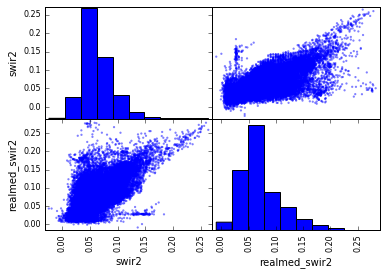

In [6]:
_ = pd.plotting.scatter_matrix(no_changes[['swir2', 'realmed_swir2']], marker='.')

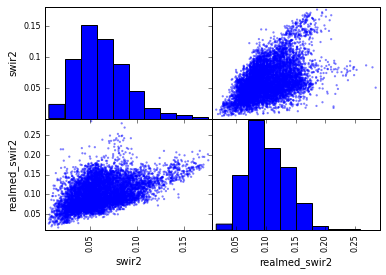

In [7]:
_ = pd.plotting.scatter_matrix(changes[['swir2', 'realmed_swir2']], marker='.')

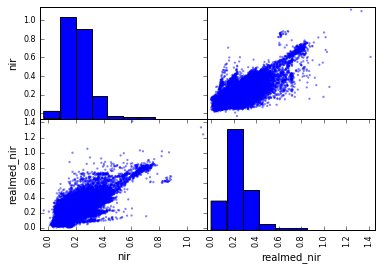

In [8]:
_ = pd.plotting.scatter_matrix(no_changes[['nir', 'realmed_nir']], marker='.')

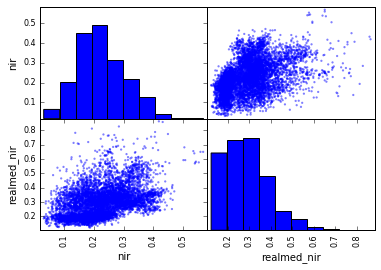

In [9]:
_ = pd.plotting.scatter_matrix(changes[['nir', 'realmed_nir']], marker='.')

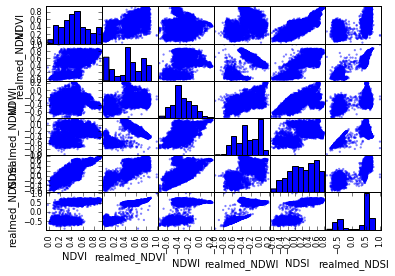

In [10]:
_ = pd.plotting.scatter_matrix(changes[['NDVI', 'realmed_NDVI', 'NDWI', 'realmed_NDWI', 'NDSI', 'realmed_NDSI']], marker='.')

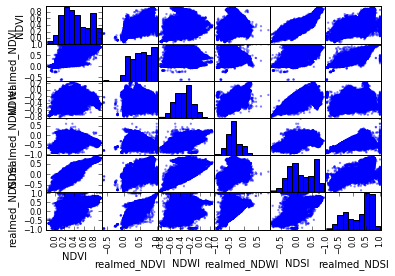

In [11]:
_ = pd.plotting.scatter_matrix(no_changes[['NDVI', 'realmed_NDVI', 'NDWI', 'realmed_NDWI', 'NDSI', 'realmed_NDSI']], marker='.')

# Предобработка обучающего и тестового множеств

In [12]:
# Все завязано на конкретный формат файла. При необходимости - менять функцию
def prepare_data(data):
    # ['RND', 'name', 'date', 'tree_canopy_cover', 'swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI']

    
    bands = [
        'swir2', 'swir1', 'nir', 'red', 'green', 'blue',
        'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue'
    ]
    
    indices = [
        'NDVI', 'NDSI', 'NDWI', 
        'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI'
    ]
    
    inputs = bands + indices

    data['change'] = (data['name'] == 'Change').astype(int)
    
        
    # Надо выделить ID полигона (у нас много точек на полигон), чтобы избежать оптимистичной оценки из-за автокорреляции
    # С большой вероятностью случайное число в поле RND уникально для разных полигонов
    
    addons = ['RND', 'dayNumber', 'tree_canopy_cover', 'change']
    # addons = ['system:index', 'change']
        
    # names = set(inputs) - set(['name'])
    names = inputs + addons
    print(names)
    return data[names]
  



In [13]:
train_data = prepare_data(df_train.copy())
test_data = prepare_data(df_test.copy())

train_data.head()

['swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI', 'RND', 'dayNumber', 'tree_canopy_cover', 'change']
['swir2', 'swir1', 'nir', 'red', 'green', 'blue', 'realmed_swir2', 'realmed_swir1', 'realmed_nir', 'realmed_red', 'realmed_green', 'realmed_blue', 'NDVI', 'NDSI', 'NDWI', 'realmed_NDVI', 'realmed_NDSI', 'realmed_NDWI', 'RND', 'dayNumber', 'tree_canopy_cover', 'change']


swir2     swir1       nir       red     green      blue  realmed_swir2  \
0  0.039435  0.042280  0.146499  0.101039  0.107351  0.100930         0.0420   
1  0.071455  0.079833  0.264124  0.199844  0.193009  0.182242         0.0896   
2  0.069890  0.076418  0.263247  0.194148  0.194195  0.185526         0.0791   
3  0.048899  0.052959  0.187316  0.141044  0.143904  0.137983         0.0737   
4  0.038058  0.044433  0.148622  0.087296  0.092052  0.086108         0.0579   

   realmed_swir1  realmed_nir  realmed_red   ...        NDVI      NDSI  \
0         0.0603       0.2673       0.2344   ...    0.152891 -0.208550   
1         0.0957       0.3952       0.3487   ...    0.155118 -0.383919   
2         0.1007       0.4005       0.3487   ...    0.201213 -0.378921   
3         0.0805       0.4377       0.4256   ...    0.139646 -0.290674   
4         0.0855       0.3420       0.2835   ...    0.214587 -0.105609   

       NDWI  realmed_NDVI  realmed_NDSI  realmed_NDWI       RND  dayNumber  \
0 -0.358013      0.065577     -0.590770     -0.631868  0.569619   0.010959   
1 -0.520512      0.062508     -0.569307     -0.610104  0.569619   0.010959   
2 -0.565559      0.069140     -0.551847     -0.598164  0.569619   0.010959   
3 -0.419531      0.014016     -0.681881     -0.689309  0.569619   0.010959   
4 -0.350659      0.093525     -0.536585     -0.600000  0.569619   0.010959   

   tree_canopy_cover  change  
0               0.62       1  
1               0.60       1  
2               0.68       1  
3               0.64       1  
4               0.64       1  

[5 rows x 22 columns]

In [14]:
def split_data(data, train_val_test=0.66, group='RND'):
  np.random.seed(1)
  ids = set(data[group])
  count = len(ids)
  print('Found %s unique areas' % (count))

  train_count = int(count * train_val_test)
  
  train = np.random.choice(list(ids), train_count, False)

  val_ids = ids.difference(set(train))
  val = np.array(list(val_ids))
  
  train = data[data[group].isin(train)]
  val = data[data[group].isin(val)]
  
  train = np.array(train.drop(labels=[group], axis=1))
  val = np.array(val.drop(labels=[group], axis=1))

  return train, val
  

# Обучение модели

In [15]:
def get_batch(data, size, input_count):
    batch = data[np.random.randint(data.shape[0], size=size), :]

    # add a little of noise
    errors = np.random.uniform(low=-0.0001, high=0.0001, size=(size, input_count))
    x = batch[:, :input_count]
    x += + errors
    

    y = batch[:, input_count:]
    
    return x, y
 

In [16]:
def print_model(x_test, y_test):
    model_dir = '.'
    result_filename_prefix = 'res_'
    
    """   
    inference_graph = tf.Graph()
    with tf.Session(graph=inference_graph) as sess:
        loader = tf.train.import_meta_graph(os.path.join(model_dir, model_name+".meta"))
        loader.restore(sess, os.path.join(model_dir, model_name))

        # x = tf.placeholder(tf.float32, [None, input_count])
        # y_ = tf.placeholder(tf.int32, [None, out_count])

        _loss = inference_graph.get_tensor_by_name('loss:0')
        _loss1 = inference_graph.get_tensor_by_name('loss1:0')
        _x = inference_graph.get_tensor_by_name('input:0')
        _y = inference_graph.get_tensor_by_name('target:0')

        _W1 = inference_graph.get_tensor_by_name('weights/w1:0')
        _W2 = inference_graph.get_tensor_by_name('weights/w2:0')
        _W3 = inference_graph.get_tensor_by_name('weights/w3:0')

        _b1 = inference_graph.get_tensor_by_name('biases/b1:0')
        _b2 = inference_graph.get_tensor_by_name('biases/b2:0')
        _b3 = inference_graph.get_tensor_by_name('biases/b3:0')



        print('test ACC:\t', sess.run(_loss, feed_dict={_x: x_test,_y: y_test}))
        print('test ACC1:\t', sess.run(_loss1, feed_dict={_x: x_test,_y: y_test}))
    """
    
    print('test ACC:\t', sess.run(loss, feed_dict={x: x_test, y_: y_test}))
    print('test ACC1:\t', sess.run(loss1, feed_dict={x: x_test, y_: y_test}))

    bestW1, bestW2, bestW3, bestB1, bestB2, bestB3 = sess.run([W1, W2, W3, b1, b2, b3])

    try:
        os.makedirs(model_dir)
    except OSError as e:
        pass  #raise
        
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'w1.txt'), bestW1, delimiter=', ', newline='],\n[', header='[\n', footer='', comments='')
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'b1.txt'), bestB1, delimiter=', ', newline=',\n', header='[\n', footer=']', comments='')

    np.savetxt(os.path.join(model_dir, result_filename_prefix+'w2.txt'), bestW2, delimiter=', ', newline='],\n[', header='[\n[', footer=']', comments='')
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'b2.txt'), bestB2, delimiter=', ', newline=',\n', header='[\n', footer=']', comments='')

    np.savetxt(os.path.join(model_dir, result_filename_prefix+'w3.txt'), bestW3, delimiter=', ', newline='],\n[', header='[\n[', footer=']', comments='')
    np.savetxt(os.path.join(model_dir, result_filename_prefix+'b3.txt'), bestB3, delimiter=', ', newline=',\n', header='[\n', footer=']', comments='')




In [17]:
def model(x, W1, W2, W3, b1, b2, b3):
    # tf.summary.histogram('w3', W3)
    # tf.summary.histogram('b3', b3)

    l1 = tf.nn.relu(tf.matmul(x, W1) + b1)
    # tf.summary.histogram('l1', l1)

    l2 = tf.nn.relu(tf.matmul(l1, W2) + b2)
    # tf.summary.histogram('l2', l2)

    l3_logits = tf.matmul(l2, W3) + b3
    # tf.summary.histogram('l3_logits', l3_logits)

    return l3_logits

In [18]:
test = np.array(test_data.drop(labels=['RND'], axis=1))
test = np.float32(test)


train, val = split_data(train_data.copy())

Found 1446 unique areas


In [29]:
layer1 = 15
layer2 = 5

summaries_dir = '.'
model_dir = '.'
max_epoch = 10000


out_count = 1
input_count = train.shape[1] - out_count


x = tf.placeholder(tf.float32, [None, input_count], name='input')

with tf.name_scope('weights'):
    W1 = tf.Variable(tf.truncated_normal([input_count, layer1], stddev=0.5), name='w1')
    W2 = tf.Variable(tf.truncated_normal([layer1, layer2], stddev=0.5), name='w2')
    W3 = tf.Variable(tf.truncated_normal([layer2, out_count], stddev=0.5), name='w3')

with tf.name_scope('biases'):
    b1 = tf.Variable(tf.zeros([layer1]), name='b1')
    b2 = tf.Variable(tf.zeros([layer2]), name='b2')
    b3 = tf.Variable(tf.zeros([out_count]), name='b3')

logits = model(x, W1, W2, W3, b1, b2, b3)
y = tf.sigmoid(logits, name='result')


# Define loss and optimizer
y_ = tf.placeholder(tf.int32, [None, out_count], name='target')

loss1 = tf.reduce_mean(
    tf.losses.absolute_difference(labels=y_, predictions=y), name='loss1')
# tf.summary.scalar('abs_diff', loss1)

reg_w = 0.0005
loss = tf.reduce_mean(
    tf.losses.sparse_softmax_cross_entropy(labels=[y_], logits=[tf.transpose([-logits, logits])]) +
    # loss1 + 
    reg_w*(tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)),
    name='loss'
)


optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
optimizer = optimizer.minimize(loss)

sess = tf.InteractiveSession()

tf.global_variables_initializer().run()
# Train
best_loss = 9999999999999
for epoch in range(max_epoch):
    batch_xs, batch_ys = get_batch(train, 2**12, input_count)
    
    _, train_loss, train_loss1 = sess.run(
        [optimizer, loss, loss1], feed_dict={x: batch_xs, y_: batch_ys}
    )
    
    # Test trained model
    if epoch % 100 == 99:
        val_loss = sess.run(loss, feed_dict={x: val[:, :input_count], y_: val[:, input_count:]})
        print('EPOCH', epoch+1, '\tVal Loss =', val_loss, 'Loss1: \tval', sess.run(loss1, feed_dict={x: val[:, :input_count], y_: val[:, input_count:]}), '\ttrain', train_loss1)

        if val_loss < best_loss:
            best_loss = val_loss

          
print('Best val LOSS:', best_loss)
test_loss, test_loss1 = sess.run(
        [loss, loss1], feed_dict={x: test[:, :input_count], y_: test[:, input_count:]})

print('Test Loss1 =', test_loss1, 'Test Loss =', test_loss)

print_model(test[:, :input_count], test[:, input_count:])


y_pred_vec = sess.run(y, feed_dict={x: val[:, :input_count]})
y_pred_vec = (y_pred_vec>0.5).astype(int)
y_true_vec = val[:, input_count:]

conf_mat = confusion_matrix(y_true_vec, y_pred_vec)
print('ConfMatr Val')
print(pd.DataFrame(conf_mat))

print('VAL AUC:',roc_auc_score(y_true_vec, y_pred_vec))


y_pred_vec = sess.run(y, feed_dict={x: test[:, :input_count]})
y_pred_vec = (y_pred_vec>0.5).astype(int)
y_true_vec = test[:, input_count:]

conf_mat = confusion_matrix(y_true_vec, y_pred_vec)
print('ConfMatr Test')
print(pd.DataFrame(conf_mat))

print('Test AUC:', roc_auc_score(y_true_vec, y_pred_vec))

EPOCH 100 	Val Loss = 0.343464 Loss1: 	val 0.256821 	train 0.253178
EPOCH 200 	Val Loss = 0.337804 Loss1: 	val 0.232089 	train 0.213998
EPOCH 300 	Val Loss = 0.322702 Loss1: 	val 0.229355 	train 0.205074
EPOCH 400 	Val Loss = 0.312915 Loss1: 	val 0.210746 	train 0.191584
EPOCH 500 	Val Loss = 0.29893 Loss1: 	val 0.206325 	train 0.186299
EPOCH 600 	Val Loss = 0.302945 Loss1: 	val 0.204992 	train 0.18555
EPOCH 700 	Val Loss = 0.289851 Loss1: 	val 0.194749 	train 0.168315
EPOCH 800 	Val Loss = 0.288971 Loss1: 	val 0.19426 	train 0.165143
EPOCH 900 	Val Loss = 0.327128 Loss1: 	val 0.174963 	train 0.157506
EPOCH 1000 	Val Loss = 0.279031 Loss1: 	val 0.184916 	train 0.147862
EPOCH 1100 	Val Loss = 0.293868 Loss1: 	val 0.177345 	train 0.148037
EPOCH 1200 	Val Loss = 0.2936 Loss1: 	val 0.175769 	train 0.155667
EPOCH 1300 	Val Loss = 0.291315 Loss1: 	val 0.173403 	train 0.14038
EPOCH 1400 	Val Loss = 0.281048 Loss1: 	val 0.184387 	train 0.150722
EPOCH 1500 	Val Loss = 0.315599 Loss1: 	val 0.169

In [30]:
print('Test AUC:',roc_auc_score(y_true_vec, y_pred_vec))

Test AUC: 0.860491718477


In [31]:
tmp = 2*np.random.uniform(size=20) - 1
print(repr(tmp))

sess.run(y, feed_dict={x: tmp.reshape((-1, 20))})

array([ 0.6329498 ,  0.89575012, -0.04110466, -0.86568801, -0.72950874,
       -0.2777415 , -0.66981195, -0.30403852,  0.19088628,  0.9648599 ,
        0.11593915, -0.34415176, -0.0692281 ,  0.46466214, -0.15529026,
        0.27120405,  0.64928337,  0.75540974,  0.98443046, -0.44200407])


array([[ 0.10362322]], dtype=float32)

In [22]:
train

array([[ 0.03943496,  0.0422798 ,  0.14649923, ...,  0.0109589 ,
         0.62      ,  1.        ],
       [ 0.07145481,  0.07983349,  0.26412398, ...,  0.0109589 ,
         0.6       ,  1.        ],
       [ 0.06988988,  0.07641799,  0.26324686, ...,  0.0109589 ,
         0.68      ,  1.        ],
       ..., 
       [ 0.03866022,  0.05249182,  0.14156432, ...,  0.08767124,
         0.68      ,  0.        ],
       [ 0.03521898,  0.04971988,  0.13708918, ...,  0.08767124,
         0.65      ,  0.        ],
       [ 0.03878791,  0.05692466,  0.12961581, ...,  0.08767124,
         0.66      ,  0.        ]])